In [122]:
pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import gpflow
import warnings
warnings.filterwarnings('ignore')

In [216]:
df = pd.read_csv('VIC.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
10/17/2018 9:39,VIC,98.5,98.5,98.5,98.5,390,0
10/17/2018 9:40,VIC,98.5,98.5,98.5,98.5,760,0
10/17/2018 9:41,VIC,98.6,98.6,98.6,98.6,2060,0
10/17/2018 9:42,VIC,98.6,98.6,98.6,98.6,5540,0
10/17/2018 9:43,VIC,98.6,98.7,98.6,98.7,760,0


In [217]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2018-10-17 00:00:00,98.731579,17.0,2018.0,10.0
2018-10-17 12:00:00,98.532877,17.0,2018.0,10.0
2018-10-18 00:00:00,98.560825,18.0,2018.0,10.0
2018-10-18 12:00:00,98.788095,18.0,2018.0,10.0
2018-10-19 00:00:00,97.456140,19.0,2018.0,10.0


## Log-returns

In [218]:
df['log_returns'] = np.log(df.Close).diff()
df.dropna(inplace=True)

In [219]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index

In [220]:
start_train = '2017-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2018-10-17 12:00:00,98.532877,17.0,2018.0,10.0,-0.002015,0.0
2018-10-18 00:00:00,98.560825,18.0,2018.0,10.0,0.000284,1.0
2018-10-18 12:00:00,98.788095,18.0,2018.0,10.0,0.002303,2.0
2018-10-19 00:00:00,97.456140,19.0,2018.0,10.0,-0.013575,3.0
2018-10-19 12:00:00,97.825333,19.0,2018.0,10.0,0.003781,4.0


In [221]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 4].values
len(X_train)

638

In [222]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,log_returns,Index
Date/Time,,,,,,
2020-01-31 00:00:00,114.558065,31.0,2020.0,1.0,0.005629,32.0
2020-01-31 12:00:00,114.075362,31.0,2020.0,1.0,-0.004223,33.0
2020-02-03 00:00:00,113.485088,3.0,2020.0,2.0,-0.005188,34.0
2020-02-03 12:00:00,113.248315,3.0,2020.0,2.0,-0.002089,35.0
2020-02-04 00:00:00,112.682443,4.0,2020.0,2.0,-0.005009,36.0


In [223]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 4].values
len(X_predict)

414

In [224]:
y_train.reshape(-1, 1).shape

(638, 1)

In [225]:
print(gpflow.kernels.ChangePoints)

<class 'gpflow.kernels.changepoints.ChangePoints'>


In [226]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -2279.9604811537956
        x: [-6.283e-03 -1.025e+01 -1.140e+01]
      nit: 34
      jac: [-2.603e-05  6.546e-04  2.235e-04]
     nfev: 50
     njev: 50
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [227]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [228]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

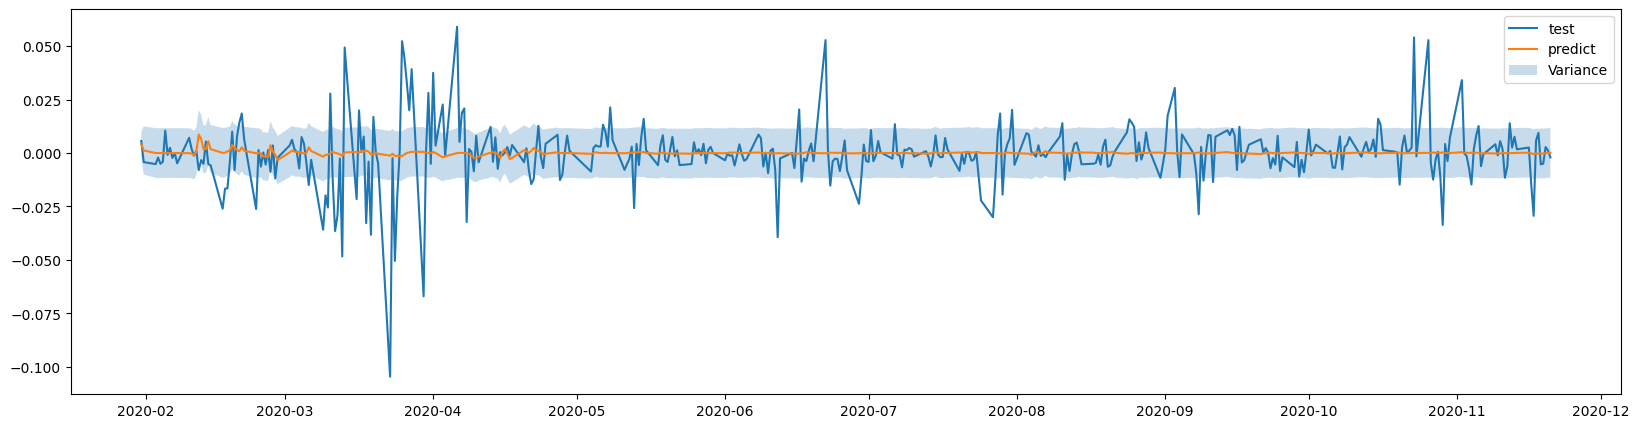

In [229]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()

## Volatility

In [230]:
df = pd.read_csv('VIC.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
10/17/2018 9:39,VIC,98.5,98.5,98.5,98.5,390,0
10/17/2018 9:40,VIC,98.5,98.5,98.5,98.5,760,0
10/17/2018 9:41,VIC,98.6,98.6,98.6,98.6,2060,0
10/17/2018 9:42,VIC,98.6,98.6,98.6,98.6,5540,0
10/17/2018 9:43,VIC,98.6,98.7,98.6,98.7,760,0


In [231]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df['Day'] = df.index.day
df['Year'], df['Month'] = df.index.year, df.index.month
df = df.resample('12H').mean().dropna()
df.head()

,Close,Day,Year,Month
Date/Time,,,,
2018-10-17 00:00:00,98.731579,17.0,2018.0,10.0
2018-10-17 12:00:00,98.532877,17.0,2018.0,10.0
2018-10-18 00:00:00,98.560825,18.0,2018.0,10.0
2018-10-18 12:00:00,98.788095,18.0,2018.0,10.0
2018-10-19 00:00:00,97.456140,19.0,2018.0,10.0


In [232]:
index = np.array([])
for year in df['Year'].unique():
    close = df.Close[df['Year'] == year]
    index = np.append(index, range(0, len(close)))
df['Index'] = index
df['vol_5'] = df['Close'].rolling(5).std()
df.dropna(inplace = True)
df

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2018-10-19 00:00:00,97.456140,19.0,2018.0,10.0,4.0,0.546349
2018-10-19 12:00:00,97.825333,19.0,2018.0,10.0,5.0,0.564630
2018-10-22 00:00:00,99.156731,22.0,2018.0,10.0,6.0,0.700210
2018-10-22 12:00:00,99.177632,22.0,2018.0,10.0,7.0,0.793166
2018-10-23 00:00:00,98.596667,23.0,2018.0,10.0,8.0,0.779120
...,...,...,...,...,...,...
2020-12-18 12:00:00,105.429070,18.0,2020.0,12.0,485.0,0.612175
2020-12-21 00:00:00,105.568142,21.0,2020.0,12.0,486.0,0.207941
2020-12-21 12:00:00,105.825758,21.0,2020.0,12.0,487.0,0.207207


In [236]:
start_train = '2018-12-25'
end_train = '2020-01-31'
df_train = df[(df.index >= start_train) & (df.index <= end_train)].iloc[:, :]
df_train.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2018-12-25 00:00:00,101.105634,25.0,2018.0,12.0,98.0,0.355771
2018-12-25 12:00:00,101.011628,25.0,2018.0,12.0,99.0,0.442093
2018-12-26 00:00:00,101.461728,26.0,2018.0,12.0,100.0,0.442386
2018-12-26 12:00:00,101.440476,26.0,2018.0,12.0,101.0,0.384143
2018-12-27 00:00:00,101.969474,27.0,2018.0,12.0,102.0,0.376566


In [237]:
X_train = np.array(df_train[['Year', 'Month', 'Day', 'Index']])
y_train = df_train.iloc[:, 5].values
len(X_train)

541

In [238]:
start_predict = '2020-01-31'
end_predict = '2020-11-22'
df_predict = df[(df.index >= start_predict) & (df.index <= end_predict)]
df_predict.head()

,Close,Day,Year,Month,Index,vol_5
Date/Time,,,,,,
2020-01-31 00:00:00,114.558065,31.0,2020.0,1.0,32.0,0.274973
2020-01-31 12:00:00,114.075362,31.0,2020.0,1.0,33.0,0.282333
2020-02-03 00:00:00,113.485088,3.0,2020.0,2.0,34.0,0.427593
2020-02-03 12:00:00,113.248315,3.0,2020.0,2.0,35.0,0.512677
2020-02-04 00:00:00,112.682443,4.0,2020.0,2.0,36.0,0.728384


In [239]:
X_predict = np.array(df_predict[['Year', 'Month', 'Day', 'Index']])
y_test = df_predict.iloc[:, 5].values
len(X_predict)

414

In [240]:
model = gpflow.models.GPR((X_train, y_train.reshape(-1, 1)),
                          kernel = gpflow.kernels.Matern32())

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 23.153610462627626
        x: [ 4.695e+00 -3.969e-01 -2.139e+01]
      nit: 32
      jac: [ 1.401e-03 -4.199e-03  5.561e-07]
     nfev: 36
     njev: 36
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [241]:
y_pred, y_var = model.predict_f(X_predict, full_cov = False)

In [242]:
y_lower = y_pred - 1.96 * np.sqrt(y_var)
y_upper = y_pred + 1.96 * np.sqrt(y_var)

### Visualization

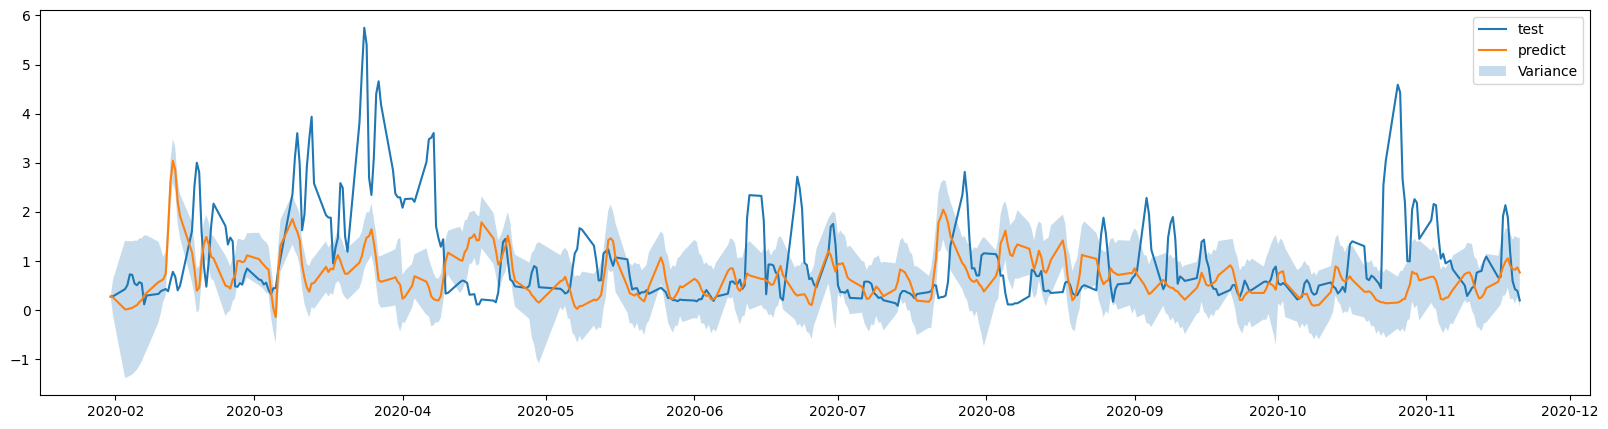

In [243]:
plt.figure(figsize=(20, 5))
plt.plot(df_predict.index, y_test, label = 'test')
plt.plot(df_predict.index, y_pred, label = 'predict')
plt.fill_between(df_predict.index, np.array(y_lower).squeeze(), np.array(y_upper).squeeze(), alpha = 0.25, label = 'Variance')
plt.legend()
plt.show()